In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = "watermelon_4.0.txt"
data_str = []
with open(path) as fr:
    lines = fr.readlines()
    for line in lines:
       data_str.append(line.split())
data = np.array(data_str).astype(np.float64)

In [3]:
def random_choose(data_, k):
    m = data_.shape[0]
    return data_[np.random.choice(m, k, replace=False)]

In [4]:
def dist(a, b, norm=2, ax=0):
    return ((np.abs(np.array(a) - np.array(b)) 
             ** norm).sum(axis=ax)) ** (1 / norm)

In [5]:
def plus_plus_choose(data, k, norm):
    m = data.shape[0]
    # method of k_means++ to choose mean vector
    mean_list = [np.random.choice(m, 1)]
    means = np.array(data[mean_list[0]])
    for i in range(k - 1):
        dis = np.zeros(m)
        for j in range(means.shape[0]):
            dis += dist(means[j], data, norm, ax=1)
        far_arg = dis.argsort()[::-1]
        for idx in range(len(far_arg)):
            if far_arg[idx] not in mean_list:
                mean_list.append(far_arg[idx])
                means = np.concatenate((means, [data[far_arg[idx]]]), axis=0)
                # print(far_arg[idx])
                break
            else:
                continue
    # print(means)
    return means

In [6]:
def k_means(data_set, k, method='pp',norm=2):
    m = data_set.shape[0]
    well_splited = False
    while not well_splited:
        if method == 'random':
            mean_vector = random_choose(data_set, k)
        elif method == 'pp':
            mean_vector = plus_plus_choose(data_set, k, norm)
        else:
            raise ValueError("Unsloved method [%s]" % method)
        Flag = True
        while Flag:
            C = []
            for i in range(k + 1):
                C.append([])
            for j in range(m):
                dj = ((np.abs((data_set[j] - mean_vector)
                          ** norm).sum(axis=1)) ** (1 / norm)).argmin()
                C[dj].append(data_set[j].tolist())
            mean_prev = mean_vector.copy()
            for i in range(k):
                mean_vector[i] = np.array(C[i]).mean(axis=0).tolist()
            mean_delta = np.min(np.abs(mean_prev - mean_vector))
            if mean_delta == 0.0:
                Flag = False
        C[k] = mean_vector[:].tolist()
        # check zero split
        sub_shape = k_shape(C)
        if 1 not in sub_shape:
#             print("Well Generated")
            well_splited = True
#         else:
#             print("Generate again...")
    return C

In [7]:
def plot_res(C_set):
    # print(len(C_set))
    k = len(C_set)-1
    color_dict = ['red', 'blue', 'yellow', 
                  'green', 'gray', 'purple', 
                  'orange', 'cyan', 'pink', 
                  'black']
    for i in range(k):
        plt.scatter(
            np.array(C_set[i])[:, 0],
            np.array(C_set[i])[:, 1],
            color=color_dict[i])
        for pt in C_set[i]:
            plt.plot(
                [pt[0], C_set[-1][i][0]],
                [pt[1], C_set[-1][i][1]],
                color='black',
                linewidth=0.8)
    plt.scatter(
        np.array(C_set[-1])[:, 0],
        np.array(C_set[-1])[:, -1],
        color=color_dict[k],
        marker='x',
        s=50)
    plt.title(k)

In [8]:
def k_shape(split_list):
    k_l = []
    for i in range(len(split_list)):
        k_l.append(len(split_list[i]))
    return k_l

In [9]:
def avg(C, norm=2):
    l_C = len(C)
    avg_c = 0.0
    for k in range(l_C):
        for i in range(len(C[k])):
            for j in range(i+1, len(C[k])):
               avg_c += dist(C[k][i], C[k][j], norm)
    avg_c = 2 * avg_c / (l_C * (l_C - 1))
    return avg_c

In [10]:
def d_min(C_1,  C_2, norm=2):
    l_1 = len(C_1)
    l_2 = len(C_2)
    min_d = float("inf")
    for i in range(l_1):
        for j in range(l_2):
            ij_d = dist(C_1[i], C_2[j], norm=norm)
            if min_d > ij_d:
                min_d = ij_d
    return min_d

In [11]:
def diam(C, norm=2):
    l_C = len(C)
    max_d = 0.0
    for i in range(l_C - 1):
        for j in range(i+1, l_C):
            ij_d = dist(C[i], C[j], norm=norm)
            if ij_d > max_d:
                max_d = ij_d
    return max_d

In [12]:
def DBI(C, norm=2):
    l_C = len(C) - 1
    db_i = 0.0
    for i in range(l_C):
        i_max = 0
        for j in range(l_C):
            if j!= i:
                tt = avg(C[i]) + avg(C[j])
                dist_ij = dist(C[l_C][i], C[l_C][j])
                # print(1/dist_ij)
                tt /= dist_ij
                if tt > i_max:
                    i_max = tt
        db_i += i_max
    db_i /= l_C
    # print(l_C, db_i)
    return db_i

In [13]:
def DI(C, norm=2):
    l_C = len(C) - 1
    min_C = float("inf")
    for i in range(l_C):
        ij_min = float("inf")
        for j in range(l_C):
            if j != i:
                tt1 = d_min(C[i], C[j])
                tt2 = 0.0
                
                for l in range(l_C):
                    tt3 = diam(C[l])
                    if tt3 > tt2:
                        tt2 = tt3
                        
                tt = tt1 / tt2
                if ij_min > tt:
                    ij_min = tt
        if min_C > ij_min:
            min_C = ij_min
    return min_C   

In [14]:
def tr(data, rule="DBI", norm=2):
    switcher = {
        "DBI" : DBI,
        "DI" : DI
    }
    if rule in switcher:
        return switcher[rule](data, norm)
    else:
        raise ValueError("Unsolved measure rule [ %s ]" % rule)

In [15]:
def best(m, rule):
    switcher = {
        "DBI" : 0,
        "DI" : -1
    }
    # print(sorted(m,key=lambda x:m[x]))
    return sorted(m,key=lambda x:m[x])[switcher[rule]]

In [16]:
def k_means_auto(data_set, rule='DBI', method='pp', norm=2, min_split=2, max_split=8):
    C = {}
    measure = {}
    for i in range(min_split, max_split+1):
        C[i] = k_means(data_set, i,method=method , norm=norm)
        measure[i] = tr(C[i], rule=rule ,norm=norm)
    best_ks = best(measure, rule=rule)
    plot_res(C[best_ks])
    
    k_data = C[best_ks]
    k_res = []
    for i in range(best_ks):
        i_res = []
        for j in range(len(k_data[i])):
            i_res.append(np.where(data==k_data[i][j])[0][0])
        k_res.append(i_res)
    return best_ks, k_res

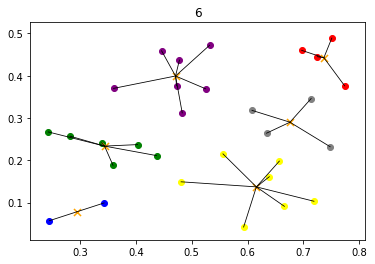

In [17]:
k, k_res = k_means_auto(data, method='pp',rule="DI", norm=2, min_split=3, max_split=8)

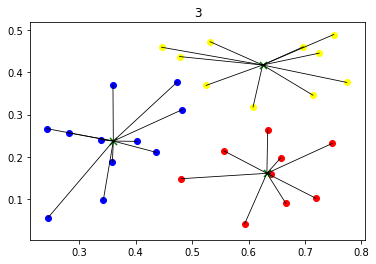

In [18]:
k, k_res = k_means_auto(data, method='pp',rule="DBI", norm=2, min_split=3, max_split=8)